In [1]:
# !pip install pytreebank
# !pip install loguru
# !pip install transformers

In [2]:
"""This module defines a configurable SSTDataset class."""

import pytreebank
import torch
from loguru import logger
from transformers import RobertaTokenizer
from torch.utils.data import Dataset

logger.info("Loading the tokenizer")
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

logger.info("Loading SST")
sst = pytreebank.load_sst()


def rpad(array, n=70):
    """Right padding."""
    current_len = len(array)
    if current_len > n:
        return array[: n - 1]
    extra = n - current_len
    return array + ([0] * extra)


def get_binary_label(label):
    """Convert fine-grained label to binary label."""
    if label < 2:
        return 0
    if label > 2:
        return 1
    raise ValueError("Invalid label")


class SSTDataset(Dataset):
    """Configurable SST Dataset.
    
    Things we can configure:
        - split (train / val / test)
        - root / all nodes
        - binary / fine-grained
    """

    def __init__(self, split="train", root=True, binary=True):
        """Initializes the dataset with given configuration.

        Args:
            split: str
                Dataset split, one of [train, val, test]
            root: bool
                If true, only use root nodes. Else, use all nodes.
            binary: bool
                If true, use binary labels. Else, use fine-grained.
        """
        logger.info(f"Loading SST {split} set")
        self.sst = sst[split]

        logger.info("Tokenizing")
        if root and binary:
            self.data = [
                (
                    rpad(
                        tokenizer.encode("[CLS] " + tree.to_lines()[0] + " [SEP]"), n=66
                    ),
                    get_binary_label(tree.label),
                )
                for tree in self.sst
                if tree.label != 2
            ]
        elif root and not binary:
            self.data = [
                (
                    rpad(
                        tokenizer.encode("[CLS] " + tree.to_lines()[0] + " [SEP]"), n=66
                    ),
                    tree.label,
                )
                for tree in self.sst
            ]
        elif not root and not binary:
            self.data = [
                (rpad(tokenizer.encode("[CLS] " + line + " [SEP]"), n=66), label)
                for tree in self.sst
                for label, line in tree.to_labeled_lines()
            ]
        else:
            self.data = [
                (
                    rpad(tokenizer.encode("[CLS] " + line + " [SEP]"), n=66),
                    get_binary_label(label),
                )
                for tree in self.sst
                for label, line in tree.to_labeled_lines()
                if label != 2
            ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X, y = self.data[index]
        X = torch.tensor(X)
        return X, y


/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/baileywei/miniconda3/

In [4]:
from tqdm import tqdm
# bert = torch.load('bert-large-uncased__root__fine__e5.pickle', map_location=torch.device('cpu'))
roberta = torch.load('roberta-large__root__fine__e5_591.pickle', map_location=torch.device('cpu'))

/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_roberta.RobertaForSequenceClassification' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_roberta.RobertaModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/baileywei/miniconda3/envs/ml_venv/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transforme

In [5]:
dataset = SSTDataset("test", root=True, binary=False)

remove_iter = 0 

while remove_iter < 3:
    for x in dataset.data:
        if len(x[0]) != 66:
            dataset.data.remove(x)
    remove_iter += 1

# for x in devset.data:
#   if len(x[0]) != 66:
#     devset.data.remove(x)

# for x in testset.data:
#   if len(x[0]) != 66:
#     testset.data.remove(x)

batch_size = 32
device = torch.device('cpu')
generator = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

roberta_pred = torch.LongTensor([])
roberta_actual = torch.LongTensor([])

roberta.eval()
with torch.no_grad():
    for batch, labels in tqdm(generator):
        batch, labels = batch.to(device), labels.to(device)
        logits = roberta(batch)[0]
        batch_pred = torch.argmax(logits, axis=1)
        roberta_pred = torch.cat((roberta_pred, batch_pred), 0)
        roberta_actual = torch.cat((roberta_actual, labels), 0)

2020-05-08 16:15:48.146 | INFO     | __main__:__init__:54 - Loading SST test set
2020-05-08 16:15:48.147 | INFO     | __main__:__init__:57 - Tokenizing
 41%|████▏     | 29/70 [02:19<03:14,  4.73s/it]A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your tokenize.encode()or tokenizer.convert_tokens_to_ids().


 84%|████████▍ | 59/70 [04:45<00:52,  4.80s/it]A sequence with no special tokens has been passed to the RoBERTa model. This model requires special tokens in order to work. Please specify add_special_tokens=True in your tokenize.encode()or tokenizer.convert_tokens_to_ids().


100%|██████████| 70/70 [05:47<00:00,  4.97s/it]


In [6]:
import sklearn
acc = sklearn.metrics.accuracy_score(roberta_pred.numpy(), 
                                     roberta_actual.numpy())
acc

0.564961521050249

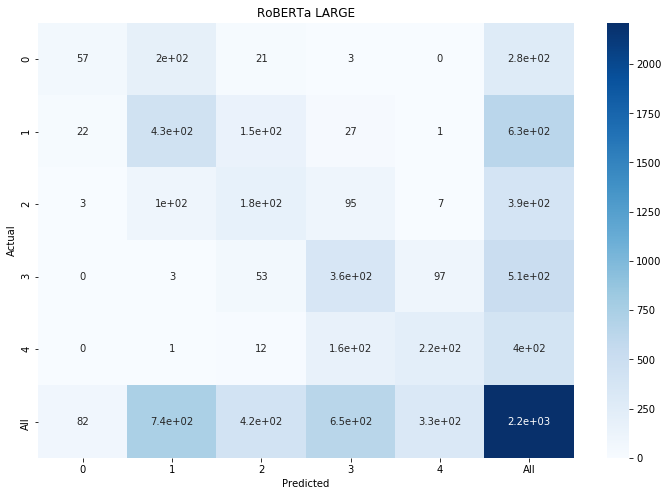

In [7]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    roberta_actual.numpy(),
        'y_Predicted': roberta_pred.numpy()
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

plt.figure(figsize=(12,8))
plt.title('RoBERTa LARGE')
sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()